# Modelling transcriptional regulation using GPs

This notebook defines the three kernels used to model the latent force function which controls the expression levels of the 5 p53-modulated genes:

- $K_{xx}(t',t)$: The covariance function between the gene expressions measured at times $t'$ and $t$
- $K_{ff}(t',t)$: The covariance function between the transcription rate (latent force function) at times $t'$ and $t$
- $K_{xf}(t',t)$: The 'cross-covariance' function between the rate of transcription (latent) and gene expression (measured) at times $t'$ and $t$

In [1]:
import numpy as np
import gpjax as gpx
import os
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dataclasses import dataclass
import jax.random as jr
from jax import jit

from p53_dataset import JAXP53_Data, load_barenco_data, flatten_dataset_jax
jax.config.update('jax_enable_x64', True)

from matplotlib import rcParams

plt.style.use("https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle")

# Check if LaTeX is in notebook path
if os.environ.get('PATH') is not None:
    if 'TeX' not in os.environ['PATH']:
        os.environ['PATH'] += os.pathsep + '/Library/TeX/texbin'

colors = rcParams["axes.prop_cycle"].by_key()["color"]

/opt/anaconda3/envs/project_wp289/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [2]:
# Load the data
data_dir = os.path.join(os.getcwd(), '..', 'data')
(original_genes_df, genes_transformed), (tfs_df, tfs_transformed), gene_var, tf_var, times = load_barenco_data(data_dir)

p53_data = JAXP53_Data(replicate=3)
train_t , train_y = flatten_dataset_jax(p53_data)

# Set random key
key = jr.PRNGKey(123)

# Prepare data (GPJax expects inputs as a 2D array)
X = train_t.reshape(-1, 1) # Repeated time points
Y = train_y.reshape(-1, 1) # Expression levels

x_test = np.linspace(0, 12, 100).reshape(-1, 1)
p53_gpjax_dataset = gpx.Dataset(X, Y)

In [3]:
# Define basal transcription rate (B), transcript degradation rate (D), sensitivity of gene (S)
def params_ground_truth():
    B_exact = np.array([0.0649, 0.0069, 0.0181, 0.0033, 0.0869])
    S_exact = np.array([0.9075, 0.9748, 0.9785, 1.0000, 0.9680])
    D_exact = np.array([0.2829, 0.3720, 0.3617, 0.8000, 0.3573])
    return B_exact, S_exact, D_exact

# Define transcription rates measured by Barenco et al. (plotted points on GP graph)
f_observed = np.array([0.1845,1.1785,1.6160,0.8156,0.6862,-0.1828, 0.5131])

Prior over the latent function $f$ is taken to be RBF kernel:

\begin{equation}
k_{ff}(t,t') = \exp \left(-\frac{(t-t')^2}{l^2}\right)
\end{equation}

Given that gene expression is related to $f$ via:

$$
x_{j}(t) = \frac{B_{j}}{D_{j}} + L_{j}[f](t)
$$

Then:

$$
\text{Cov}(L_{j}[f](t), L_{k}[f](t')) = L_{j} \otimes L_{k}k_{ff}
$$

Or:

$$
k_{x_{j}x_{k}}(t,t') = S_{j}S_{k}e^{-D_{j}t-D_{k}t'}\int_{0}^{t}e^{D_{j}u}\int_{0}^{t'}e^{D_{k}u'}k_{ff}(u,u')\mathrm{d} u'\mathrm{d} u
$$

If the RBF kernel is used as the base kernel, this can be analytically solved to give the following expression for the covariance function:

\begin{equation}
k_{x_{j}x_{k}}(t,t') = S_{j}S_{k}\frac{\sqrt{\pi}l}{2}[h_{kj}(t,t') + h_{kj}(t',t)]
\end{equation}\tag{2}

where

\begin{align*}
h_{kj}(t,t') &= \frac{\exp(\gamma_{k})^{2}}{D_{j} + D_{k}} \left\{ \exp[-D_{k}(t'-t)] \right. \\
&\quad \left. \left[ \text{erf} \left(\frac{t'-t}{l_{r}} - \gamma_{k}\right) + \text{erf} \left(\frac{t}{l_{r}} + \gamma_{k} \right) \right]  \right. \\
&\quad \left. - \exp[-(D_{k}t'+D_{j}t)] \left[ \text{erf} \left(\frac{t'}{l_{r}} - \gamma_{k}\right) + \text{erf} \left(\gamma_{k} \right) \right] \right\}
\end{align*}

where $\textrm{erf}(x)$ is the real-valued error function, $\textrm{erf}(x) = \frac{2}{\sqrt{\pi}}\int_{0}^{x} \textrm{exp}(-y^{2}) \mathrm{d} y$, and $\gamma_{k} = \frac{D_{k}l}{\sqrt{2}}$.

Similarly, the cross-covariance can be analytically described as follows if the RBF kernel is used as a prior:

\begin{equation}
k_{x_{j}f_{r}}(t,t') = \frac{S_{rj}\sqrt{\pi}l_{r}}{2} \textrm{exp}(\gamma_{j})^{2}\textrm{exp}(-D_{j}(t'-t)) \biggl[ \textrm{erf} \left (\frac{t'-t}{l_{r}} - \gamma_{k}\right ) + \textrm{erf} \left (\frac{t}{l_{r}} +\gamma_{k} \right ) \biggr]
\end{equation}\tag{3}


In [32]:
num_genes = 5
# Dummy variables for parameters to optimise for
lengthscale = 2.5
decays = jnp.array([0.2829, 0.3720, 0.3617, 0.8000, 0.3573])
senstivities = jnp.array([0.9075, 0.9748, 0.9785, 1.0000, 0.9680])
noise = jnp.array([0.001, 0.001, 0.001, 0.001, 0.001])

# Plotting kernels
def plot_cov_heatmap(cov_matrix, title='Covariance Matrix'):

    plt.figure(figsize=(10, 6))
    plt.imshow(cov_matrix, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Generate test points
time_points = jnp.linspace(0, 12, 100)

t1 = jnp.repeat(time_points[None, :], num_genes, axis=0).flatten()
t2 = t1

time_noise = jax.random.uniform(key, shape=t1.shape, minval=-0.1, maxval=0.1)

t3= t1 + time_noise

t4 = jnp.linspace(0, 12, 50)
t4 = jnp.repeat(t4[None, :], num_genes, axis=0).flatten()

In [6]:
# Implementation of Kxx

def Kxx(t1, t2):
    vert_block_size = t1.shape[0] // num_genes
    horiz_block_size = t2.shape[0] // num_genes

    t1_block = t1[:vert_block_size]
    t2_block = t2[:horiz_block_size]

    shape = shape = (vert_block_size * num_genes, horiz_block_size * num_genes)
    K_xx = jnp.zeros(shape)

    # Fill in covariance matrix
    for j in range(num_genes):
        for k in range(num_genes):
            kxx = _kxx(j, k, t1_block, t2_block)
            #kxx = 0.7
            K_xx = K_xx.at[j * vert_block_size:(j + 1) * vert_block_size,
                               k * horiz_block_size:(k + 1) * horiz_block_size].set(kxx)
    
    # Add jitter
    if horiz_block_size == vert_block_size:
        jitter = 1e-3 * jnp.eye(K_xx.shape[0])
        K_xx += jitter
        #TODO: look at variance (add to likelihood)
        
    return K_xx

def _kxx(j, k, t1_block, t2_block):
    """
    Equation 5 in paper k_xx(t, t')

    Parameters
    ----------
    j, k : int
        Index of jth and kth gene.
    t1_block, t2_block : array
        Block of time points for gene expressions at times t and t'. Shape (n,)
    """

    t1_block = t1_block.reshape(-1, 1)
    t2_block = t2_block.reshape(1, -1)

    mult = senstivities[j] * senstivities[k] * lengthscale * jnp.sqrt(jnp.pi) * 0.5
    second_term = _h(k, j, t2_block, t1_block) + _h(j, k, t1_block, t2_block)

    kxx = mult * second_term
    return kxx


def _h(j,k,t1,t2):
    """
    Analytical solution for the convolution of the exponential kernel with a step function.

    Parameters
    ----------
    j, k : int
        Index of jth and kth gene.
    t1, t2 : float
        time one and time two
    """
    t_dist = t2 - t1

    multiplier = jnp.exp(_gamma(k)**2) / (decays[j] + decays[k])

    first_multiplier = jnp.exp(-decays[k]*t_dist)
    first_erf_terms = jax.scipy.special.erf((t_dist / lengthscale) - _gamma(k)) + jax.scipy.special.erf(t1/lengthscale + _gamma(k))

    second_multiplier = jnp.exp(-(decays[k]*t2 + decays[j]*t1))
    second_erf_terms = jax.scipy.special.erf((t2 / lengthscale) - _gamma(k)) + jax.scipy.special.erf(_gamma(k))

    result = multiplier * (jnp.multiply(first_multiplier, first_erf_terms) - jnp.multiply(second_multiplier, second_erf_terms))

    return result


def _gamma(k):
    # Gamma term for h function
    return (decays[k] * lengthscale) / 2

In [31]:
t1.shape, t2.shape

((500,), (500,))

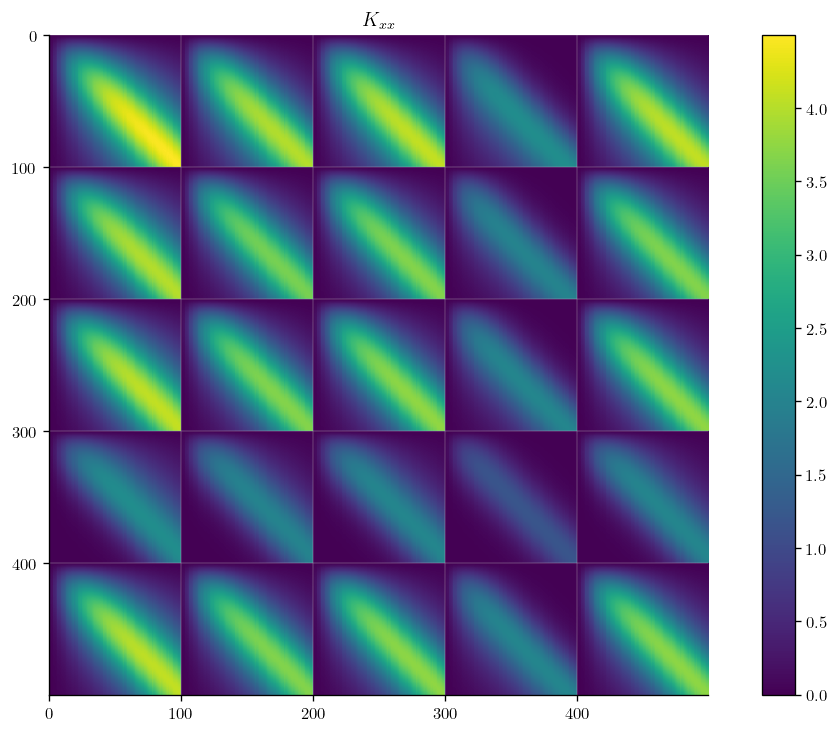

In [8]:
K_xx = Kxx(t1, t3)
plot_cov_heatmap(K_xx, '$K_{xx}$')

In [9]:
# Implementation of cross-covariance matrix Kxf

def Kxf(x, f):
    """
    Cross-covariance between gene expressions at time t' and f at time t.
    Equation 6 in paper

    Parameters
    ----------
    x : array
        Time points for gene expressions at times t'. Shape (n,)
    f : array
        Time points for f at times t. Shape (m,)
    """
    # Get shape (n, m)
    K_xf = jnp.zeros((x.shape[0], f.shape[0]))
    block_size = x.shape[0] // num_genes #7
    t1_block = x[:block_size].reshape(-1, 1)
    t2_block = f.reshape(1, -1)

    for j in range(num_genes):
        kxf = _kxf(j, t1_block, t2_block)
        K_xf = K_xf.at[j * block_size:(j + 1) * block_size].set(kxf)
    
    return K_xf

def _kxf(j, t_x, t_f):
    l = lengthscale
    t_dist = t_x - t_f
    
    first_term = 0.5 * l * jnp.sqrt(jnp.pi) * senstivities[j]
    first_expon_term = jnp.exp(_gamma(j)**2)
    second_expon_term = jnp.exp(-decays[j]*t_dist)
    erf_terms = jax.scipy.special.erf((t_dist / l) - _gamma(j)) + jax.scipy.special.erf(t_f/l + _gamma(j))

    kxf = first_term * first_expon_term * second_expon_term * erf_terms

    return kxf  

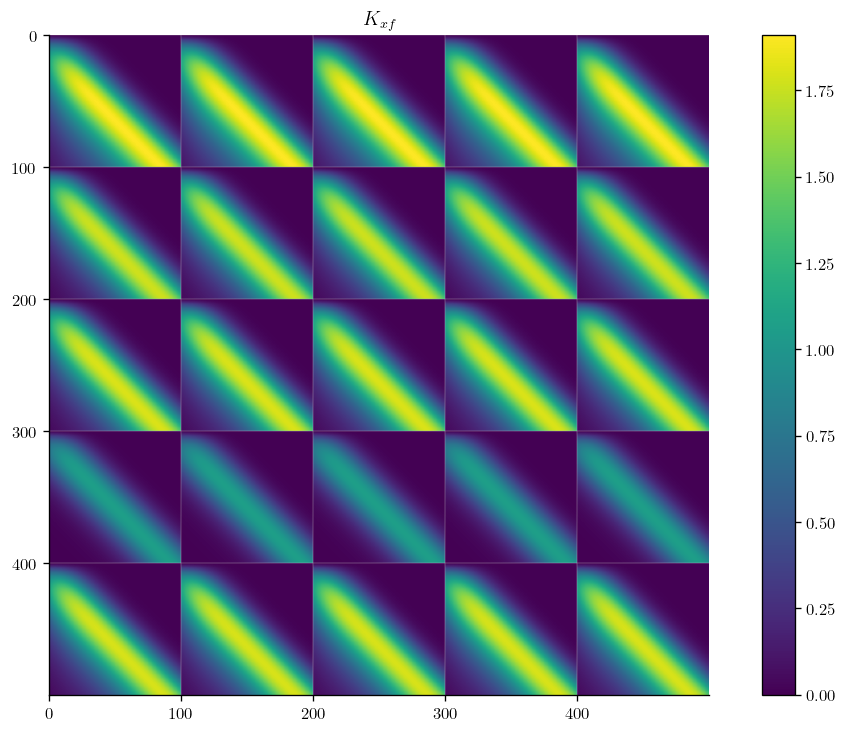

In [42]:
K_xf = Kxf(t1, t2)
plot_cov_heatmap(K_xf, '$K_{xf}$')

In [11]:
# Implementation of Kff (RBF kernel)

def Kff(t1, t2):
    """
    Covariance between f at times t' and t.
    RBF
    """
    # Unsure if calling RBF kernel would be quicker
    
    # Ensure inputs are column vectors
    t1 = t1.reshape(-1, 1)
    t2 = t2.reshape(1, -1)

    rbf = jnp.exp(-0.5 * jnp.square(t1 - t2) / jnp.square(lengthscale))
    if rbf.shape[0] == rbf.shape[1]:
        jitter = 1e-3 * jnp.eye(rbf.shape[0])
        rbf += jitter
    return rbf

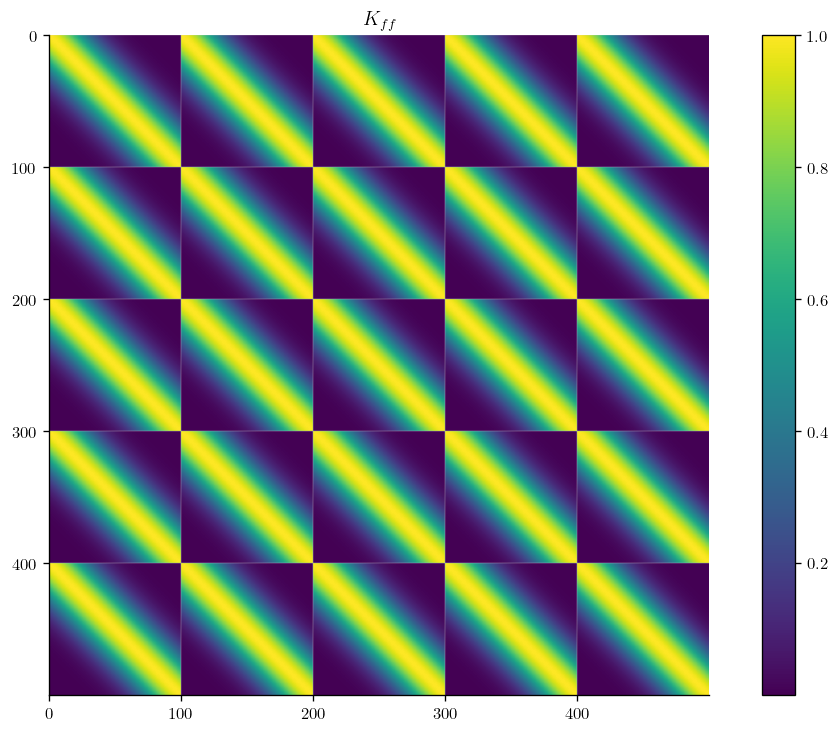

In [12]:
K_ff = Kff(t1, t2)
plot_cov_heatmap(K_ff, '$K_{ff}$')

## Increasing dimensionality of inputs

Given X (time-points $t$) and Y (measured gene expressions $x_{i}$) and the following defined kernels:

1. $k_{x_{j}x_{k}}(t,t')$: The covariance between the expression levels of genes $j$ and $k$ at times $t$ and $t'$
2. $k_{x_{j}f}(t,t')$: The covariance between the expression level of gene $j$ at time $t$ and the latent function at time $t'$
3. $k_{ff}(t,t')$: The covariance of the latent function evaluated at times $t$ and $t'$


It makes sense to increase the dimensionality of the data such that the gene index is passed to the kernel as well, i.e.

$$
k_{x_{j}x_{k}}(t,t') \rightarrow \hat{k}_{xx}((t, j),(t', k))
$$

$$
k_{x_{j}f}(t,t') \rightarrow \hat{k}_{xf}((t, j),t')
$$

In [13]:
for i in range(p53_data.num_outputs):
    print(p53_data[i])
    print(type(p53_data[i][0]))

(Array([ 0.,  2.,  4.,  6.,  8., 10., 12.], dtype=float64), Array([0.17238177, 0.23264388, 1.92464882, 1.22534649, 0.68403809,
       0.46037239, 0.89290156], dtype=float64))
<class 'jaxlib.xla_extension.ArrayImpl'>
(Array([ 0.,  2.,  4.,  6.,  8., 10., 12.], dtype=float64), Array([0.19510971, 0.09759664, 2.16464784, 0.89689396, 0.26302294,
       0.11858324, 0.28305556], dtype=float64))
<class 'jaxlib.xla_extension.ArrayImpl'>
(Array([ 0.,  2.,  4.,  6.,  8., 10., 12.], dtype=float64), Array([0.08857048, 0.14190979, 1.35116539, 0.94570607, 0.27215756,
       0.2544362 , 0.51773185], dtype=float64))
<class 'jaxlib.xla_extension.ArrayImpl'>
(Array([ 0.,  2.,  4.,  6.,  8., 10., 12.], dtype=float64), Array([0.01876506, 0.12216444, 1.24857003, 0.53118723, 0.16929122,
       0.11145665, 0.19135888], dtype=float64))
<class 'jaxlib.xla_extension.ArrayImpl'>
(Array([ 0.,  2.,  4.,  6.,  8., 10., 12.], dtype=float64), Array([0.20769934, 0.21061597, 1.82892805, 1.24125571, 0.5166152 ,
       0.

In [14]:
num_genes = p53_data.num_outputs
gene_data = [p53_data[i] for i in range(num_genes)]  # Collecting the data

# Extract time points and gene expression values
time_points = gene_data[0][0]  # Assuming all genes have the same time points
num_time_points = len(time_points)

# Create combined index (t, j) and corresponding expression values
combined_timepoints = []
expression_values = []

for j, (times, expressions) in enumerate(gene_data):
    for t, expr in zip(times, expressions):
        combined_timepoints.append((t, j))
        expression_values.append(expr)

# Convert to JAX arrays
combined_timepoints = jnp.array(combined_timepoints)
expression_values = jnp.array(expression_values).reshape(-1,1)

# Print to check the structure
print("Combined Indices:", combined_timepoints.shape)
print("Expression Values:", expression_values.shape)

Combined Indices: (35, 2)
Expression Values: (35, 1)


In [79]:
expression_values

Array([[0.17238177],
       [0.23264388],
       [1.92464882],
       [1.22534649],
       [0.68403809],
       [0.46037239],
       [0.89290156],
       [0.19510971],
       [0.09759664],
       [2.16464784],
       [0.89689396],
       [0.26302294],
       [0.11858324],
       [0.28305556],
       [0.08857048],
       [0.14190979],
       [1.35116539],
       [0.94570607],
       [0.27215756],
       [0.2544362 ],
       [0.51773185],
       [0.01876506],
       [0.12216444],
       [1.24857003],
       [0.53118723],
       [0.16929122],
       [0.11145665],
       [0.19135888],
       [0.20769934],
       [0.21061597],
       [1.82892805],
       [1.24125571],
       [0.5166152 ],
       [0.46197937],
       [0.64339332]], dtype=float64)

In [15]:
def aug_dataset(timepoints, gene_expressions):
    return gpx.Dataset(timepoints, gene_expressions)

dataset_train = aug_dataset(combined_timepoints, expression_values)

In [16]:
expression_values.shape

(35, 1)

In [17]:
combined_timepoints.shape

(35, 2)

In [18]:
combined_timepoints

Array([[ 0.,  0.],
       [ 2.,  0.],
       [ 4.,  0.],
       [ 6.,  0.],
       [ 8.,  0.],
       [10.,  0.],
       [12.,  0.],
       [ 0.,  1.],
       [ 2.,  1.],
       [ 4.,  1.],
       [ 6.,  1.],
       [ 8.,  1.],
       [10.,  1.],
       [12.,  1.],
       [ 0.,  2.],
       [ 2.,  2.],
       [ 4.,  2.],
       [ 6.,  2.],
       [ 8.,  2.],
       [10.,  2.],
       [12.,  2.],
       [ 0.,  3.],
       [ 2.,  3.],
       [ 4.,  3.],
       [ 6.,  3.],
       [ 8.,  3.],
       [10.,  3.],
       [12.,  3.],
       [ 0.,  4.],
       [ 2.,  4.],
       [ 4.,  4.],
       [ 6.,  4.],
       [ 8.,  4.],
       [10.,  4.],
       [12.,  4.]], dtype=float64)

## Combining Kernels

Taking from ocean modelling notebook

In [19]:
from dataclasses import dataclass, field

import jax.numpy as jnp
from jaxtyping import Float, Int

import gpjax as gpx


@dataclass
class DiagonalKernel(gpx.kernels.AbstractKernel):
    #kernel: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1])

    kernel: gpx.kernels.AbstractKernel = field(default_factory=lambda: gpx.kernels.RGB(active_dims=[0, 1]))
    # kernel: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1], lengthscale = jnp.array([0.115]), variance = jnp.array([0.404]))

    def __call__(
        self, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]
    ) -> Float[Array, "1"]:

        z = jnp.array(X[2], dtype=int)
        zp = jnp.array(Xp[2], dtype=int)

        switch = (z + zp + 1) % 2

        return switch * self.kernel(X, Xp)


NameError: name 'Array' is not defined

In [28]:
from gpjax.typing import (
    Array,
    ScalarFloat,
)

# Define kernel classes for k_xx, k_xf, k_ff and import them into a custom kernel

# Define S as a placeholder for now (TODO: make it a trainable parameter)

senstivities = jnp.array([[0.9075, 0.9748, 0.9785, 1.0000, 0.9680]])
decays = jnp.array ([0.2829, 0.3720, 0.3617, 0.8000, 0.3573])

num_genes = p53_data.num_outputs

@dataclass
class gene_xpr_kernel(gpx.kernels.AbstractKernel):
    r"Covariance for gene expressions at different times k_xx"

    name: str = "k_xx"
    
    def __call__(self, t1: Int[Array, "N 2"], t2: Int[Array, "N 2"]) -> ScalarFloat:
        """
        Calculates the covariance between gene expressions at times t and t'.
        t1 and t2 are 2D arrays with shape (N, 2) where N is the number of gene indices x time points. This is to convert $k_{x_{i}, x_{j}}(t, t')$ to $k_{xx}((t,j), (t,k))$.

        Parameters
        ----------
        t1 : Int[Array, "N 2"]
            Time points for gene expressions at times t. Shape (N, 2)
        t2 : Int[Array, "N 2"]
            Time points for gene expressions at times t'. Shape (N, 2)


        Returns
        -------
        ScalarFloat
            Covariance between gene expressions at times t and t'
        """

        # Get gene expressions measured at times t and t'
        genes_1 = jnp.unique(t1[:,1])
        genes_2 = jnp.unique(t2[:,1])

        if genes_1.size != genes_2.size:
            raise ValueError("Number of genes must be the same")
        
        num_genes = genes_1.size

        times_1 = t1[:,0]
        times_2 = t2[:,0]

        # Upsample time points
        time_points = jnp.linspace(0, 12, 100)
        times_1 = jnp.repeat(time_points[None, :], num_genes, axis=0).flatten()
        times_2 = jnp.repeat(time_points[None, :], num_genes, axis=0).flatten()

        vert_block_size = times_1.shape[0] // num_genes
        horiz_block_size = times_2.shape[0] // num_genes

        t1_block = times_1[:vert_block_size]
        t2_block = times_2[:horiz_block_size]

        shape = (vert_block_size * num_genes, horiz_block_size * num_genes)
        K_xx = jnp.zeros(shape)

        # Fill in covariance matrix
        for j in range(num_genes):
            for k in range(num_genes):
                print(t1_block.shape, t2_block.shape)
                print(type(t1_block), type(t2_block))
                kxx = _kxx(j, k, t1_block, t2_block)
                K_xx = K_xx.at[j * vert_block_size:(j + 1) * vert_block_size,
                                k * horiz_block_size:(k + 1) * horiz_block_size].set(kxx)
                
        # Add jitter
        if horiz_block_size == vert_block_size:
            jitter = 1e-3 * jnp.eye(K_xx.shape[0])
            K_xx += jitter

        return K_xx
    
    def _kxx(j, k, t1_block, t2_block):
        """
        Equation 5 in paper k_xx(t, t')

        Parameters
        ----------
        j, k : int
            Index of jth and kth gene.
        t1_block, t2_block : array
            Block of time points for gene expressions at times t and t'. Shape (n,)
        """

        t1_block = t1_block.reshape(-1, 1)
        t2_block = t2_block.reshape(1, -1)

        mult = senstivities[j] * senstivities[k] * lengthscale * jnp.sqrt(jnp.pi) * 0.5
        second_term = _h(k, j, t2_block, t1_block) + _h(j, k, t1_block, t2_block)

        kxx = mult * second_term
        return kxx
    
    def _h(j,k,t1,t2):
        """
        Analytical solution for the convolution of the exponential kernel with a step function.

        Parameters
        ----------
        j, k : int
            Index of jth and kth gene.
        t1, t2 : float
            time one and time two
        """
        t_dist = t2 - t1

        multiplier = jnp.exp(_gamma(k)**2) / (decays[j] + decays[k])

        first_multiplier = jnp.exp(-decays[k]*t_dist)
        first_erf_terms = jax.scipy.special.erf((t_dist / lengthscale) - _gamma(k)) + jax.scipy.special.erf(t1/lengthscale + _gamma(k))

        second_multiplier = jnp.exp(-(decays[k]*t2 + decays[j]*t1))
        second_erf_terms = jax.scipy.special.erf((t2 / lengthscale) - _gamma(k)) + jax.scipy.special.erf(_gamma(k))

        result = multiplier * (jnp.multiply(first_multiplier, first_erf_terms) - jnp.multiply(second_multiplier, second_erf_terms))

        return result
    
    def _gamma(k):
        # Gamma term for h function
        return (decays[k] * lengthscale) / 2



In [77]:
kernel_kxx = gene_xpr_kernel()
cov_xx = kernel_kxx(combined_timepoints, combined_timepoints)

(100,) (100,)
<class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'>
(100,) (100,)
<class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'>
(100,) (100,)
<class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'>
(100,) (100,)
<class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'>
(100,) (100,)
<class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'>
(100,) (100,)
<class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'>
(100,) (100,)
<class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'>
(100,) (100,)
<class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'>
(100,) (100,)
<class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'>
(100,) (100,)
<class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'>
(100,) (100,)
<class 'jaxlib.xla_extensi

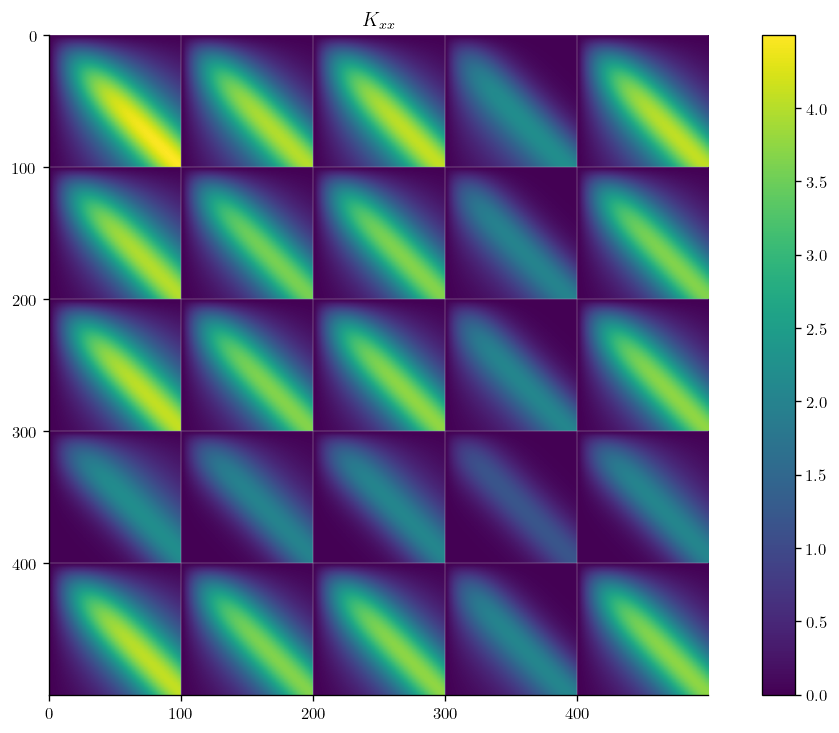

In [45]:
plot_cov_heatmap(cov_xx, '$K_{xx}$')

In [89]:
kernel_kxx = gene_xpr_kernel()
kernel_kxx(combined_timepoints, combined_timepoints)

(35, 2)
(35, 2)
1
None


1

In [69]:
from gpjax.typing import (
    Array,
    ScalarFloat,
)

t1: Int[Array, "N 2"] = combined_timepoints
isinstance(t1, Array)

True

In [ ]:
# Initialise two arrays of length 10 with different number
t1_debug = jnp.array([4,13,12,11,10,9,8,7,6,5])
t2_debug = jnp.array([1,2,3,4,5,6,7,8,9,10])

kernel = 

In [46]:
# Define test kernel which takes in a 2d input

@dataclass
class test_kernel(gpx.kernels.AbstractKernel):

    name: str = 'testkernel'

    def __call__(self, x: Float[Array, " D"], y: Float[Array, " D"]) -> ScalarFloat:

        print(x.shape, y.shape)
        print(self.ndims)
        print(self.active_dims)

        return None

In [47]:
combined_timepoints.shape

(35, 2)

In [83]:
from dataclasses import dataclass

from beartype.typing import Union
import jax.numpy as jnp
from jaxtyping import Float
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

from gpjax.base import param_field
from gpjax.kernels.base import AbstractKernel
from gpjax.kernels.stationary.utils import squared_distance
from gpjax.typing import (
    Array,
    ScalarFloat,
)

@dataclass
class RBF2(AbstractKernel):
    r"""The Radial Basis Function (RBF) kernel."""

    lengthscale: Union[ScalarFloat, Float[Array, " D"]] = param_field(
        jnp.array(1.0), bijector=tfb.Softplus()
    )
    variance: ScalarFloat = param_field(jnp.array(1.0), bijector=tfb.Softplus())
    name: str = "RBF"

    def __call__(self, x: Float[Array, " D"], y: Float[Array, " D"]) -> ScalarFloat:
        r"""Compute the RBF kernel between a pair of arrays.

        Evaluate the kernel on a pair of inputs $`(x, y)`$ with lengthscale parameter
        $`\ell`$ and variance $`\sigma^2`$:
        ```math
        k(x,y)=\sigma^2\exp\Bigg(- \frac{\lVert x - y \rVert^2_2}{2 \ell^2} \Bigg)
        ```

        Args:
            x (Float[Array, " D"]): The left hand argument of the kernel function's call.
            y (Float[Array, " D"]): The right hand argument of the kernel function's call.

        Returns:
            ScalarFloat: The value of $`k(x, y)`$.
        """

        # active_dims testing
        print(x[:3])
        print(x.shape)
        print('Slice')
        print(self.slice_input(x[:3]))
        print(self.slice_input(x).shape)
        x = self.slice_input(x) / self.lengthscale
        y = self.slice_input(y) / self.lengthscale
        K = self.variance * jnp.exp(-0.5 * squared_distance(x, y))


        print(x.shape, y.shape)
        print(x[6], y[6])

        print(self.ndims)
        print(self.active_dims)
        return K.squeeze()

rbf_test_kernel = RBF2(active_dims=[0])
rbf_test_kernel(combined_timepoints, combined_timepoints)

[[0. 0.]
 [2. 0.]
 [4. 0.]]
(35, 2)
Slice
[[0.]
 [2.]
 [4.]]
(35, 1)
(35, 1) (35, 1)
[12.] [12.]
1
[0]


Array(1., dtype=float64)

In [75]:
rbf_test_kernel.cross_covariance(combined_timepoints, combined_timepoints)

(1,) (1,)
Traced<ShapedArray(float64[])>with<BatchTrace(level=1/0)> with
  val = Array([ 0.,  2.,  4.,  6.,  8., 10., 12.,  0.,  2.,  4.,  6.,  8., 10.,
       12.,  0.,  2.,  4.,  6.,  8., 10., 12.,  0.,  2.,  4.,  6.,  8.,
       10., 12.,  0.,  2.,  4.,  6.,  8., 10., 12.], dtype=float64)
  batch_dim = 0 Traced<ShapedArray(float64[])>with<BatchTrace(level=2/0)> with
  val = Array([ 0.,  2.,  4.,  6.,  8., 10., 12.,  0.,  2.,  4.,  6.,  8., 10.,
       12.,  0.,  2.,  4.,  6.,  8., 10., 12.,  0.,  2.,  4.,  6.,  8.,
       10., 12.,  0.,  2.,  4.,  6.,  8., 10., 12.], dtype=float64)
  batch_dim = 0
1
[0]


Array([[1.00000000e+00, 1.35335283e-01, 3.35462628e-04, ...,
        1.26641655e-14, 1.92874985e-22, 5.38018616e-32],
       [1.35335283e-01, 1.00000000e+00, 1.35335283e-01, ...,
        1.52299797e-08, 1.26641655e-14, 1.92874985e-22],
       [3.35462628e-04, 1.35335283e-01, 1.00000000e+00, ...,
        3.35462628e-04, 1.52299797e-08, 1.26641655e-14],
       ...,
       [1.26641655e-14, 1.52299797e-08, 3.35462628e-04, ...,
        1.00000000e+00, 1.35335283e-01, 3.35462628e-04],
       [1.92874985e-22, 1.26641655e-14, 1.52299797e-08, ...,
        1.35335283e-01, 1.00000000e+00, 1.35335283e-01],
       [5.38018616e-32, 1.92874985e-22, 1.26641655e-14, ...,
        3.35462628e-04, 1.35335283e-01, 1.00000000e+00]], dtype=float64)

In [71]:
combined_timepoints[6]

Array([12.,  0.], dtype=float64)

Array(1., dtype=float64)

In [48]:
test_kernel()(combined_timepoints, combined_timepoints)

(35, 2) (35, 2)
1
None


In [64]:
type(t1)

jaxlib.xla_extension.ArrayImpl

check dimensionality of inputs and perform kernel operation based on dimension